In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 6
        Out dimension MaxPooling:  112 * 112 * 6
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        
        self.cnn1_Res = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=1, stride=1, padding=0) 
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 6 
        Out dimension Conv:        112 * 112 * 9
        Out dimension MaxPooling:  56  * 56  * 9
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=9, kernel_size=9, stride=1, padding=4),
            nn.ReLU()
        )
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 9
        Out dimension Conv:        56  * 56  * 12
        Out dimension MaxPooling:  28  * 28  * 12
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=12, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 12
        Out dimension Conv:        28  * 28  * 15
        Out dimension MaxPooling:  7  * 7  * 15
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.maxpool4 = nn.MaxPool2d(4, stride=4)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=735, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        residual = x
        # Convolution
        x = self.cnn1_model(x)
        # Residual
        residual = self.cnn1_Res(residual)
        x += residual
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        # Convolution
        x = self.cnn2_model(x)
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        # Max pooling
        x = self.maxpool4(x)
        
        
        
        x = torch.flatten(x,start_dim=1)
        x = self.ffnn_model(x)
        x = torch.sigmoid(x)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn1_Res): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(6, 9, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4_model): Sequential(
    (0): Conv2d(12, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (maxpool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 108152


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0494, -2.0152, -1.9809,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0152, -1.9809, -1.9809,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.7240, -1.7069, -1.7069,  ..., -1.5185, -1.5185, -1.5185],
          [-1.7240, -1.7240, -1.7240,  ..., -1.5185, -1.5357, -1.5357],
          [-1.7240, -1.7412, -1.7412,  ..., -1.5185, -1.5185, -1.5185]],

         [[-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          [-1.7556, -1.7206, -1.7031,  ..., -2.0357, -2.0357, -2.0357],
          [-1.6681, -1.6506, -1.6681,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.2304, -1.2129, -1.1954,  ..., -1.0553, -1.0728, -1.0728],
          [-1.2304, -1.2129, -1.2129,  ..., -1.0553, -1.0728, -1.0728],
          [-1.2304, -1.2304, -1.2304,  ..., -1.05

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


train loss:  0.08674767526943863
Val loss:  0.17880463185517684
train accuracy:  0.3897485493230174
Val accuracy:  0.40869565217391307
Current time: 3.438 minutes. Time expected till completion: 1715.514 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


train loss:  0.08419212900692997
Val loss:  0.16045485890429953
train accuracy:  0.39264990328820115
Val accuracy:  0.45217391304347826
Current time: 3.680 minutes. Time expected till completion: 916.240 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.07568386952236035
Val loss:  0.1530330398808355
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 3.857 minutes. Time expected till completion: 638.915 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


train loss:  0.07490636797430898
Val loss:  0.15297411110090173
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 4.027 minutes. Time expected till completion: 499.363 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.07457045971540234
Val loss:  0.15256597373796546
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 4.198 minutes. Time expected till completion: 415.608 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.07418839451883932
Val loss:  0.15355704038039497
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 4.368 minutes. Time expected till completion: 359.668 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.0735002685792211
Val loss:  0.1505313894023066
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 4.543 minutes. Time expected till completion: 319.933 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.07282400926722779
Val loss:  0.15103225189706554
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 4.715 minutes. Time expected till completion: 289.963 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.07245124239524973
Val loss:  0.14940968285436215
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 4.888 minutes. Time expected till completion: 266.656 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.07200966363257551
Val loss:  0.14896508766257244
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 5.063 minutes. Time expected till completion: 248.079 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.07147753976530448
Val loss:  0.14858881805254065
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 5.236 minutes. Time expected till completion: 232.754 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.07112682004039476
Val loss:  0.14817132535188093
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 5.412 minutes. Time expected till completion: 220.088 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.07068671784732973
Val loss:  0.1476552444955577
train accuracy:  0.4332688588007737
Val accuracy:  0.48695652173913045
Current time: 5.593 minutes. Time expected till completion: 209.510 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.07042314155419975
Val loss:  0.14742655754089357
train accuracy:  0.4410058027079304
Val accuracy:  0.48695652173913045
Current time: 5.767 minutes. Time expected till completion: 200.180 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.07010453097824894
Val loss:  0.1469384245250536
train accuracy:  0.4564796905222437
Val accuracy:  0.5478260869565217
Current time: 5.944 minutes. Time expected till completion: 192.178 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06977772620475961
Val loss:  0.14668085108632628
train accuracy:  0.47678916827852996
Val accuracy:  0.4956521739130435
Current time: 6.120 minutes. Time expected till completion: 185.122 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 30.75it/s]


train loss:  0.069722590524869
Val loss:  0.14543065506479014
train accuracy:  0.4874274661508704
Val accuracy:  0.5043478260869565
Current time: 6.295 minutes. Time expected till completion: 178.860 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06961782561971787
Val loss:  0.14588774339012478
train accuracy:  0.5145067698259188
Val accuracy:  0.5652173913043478
Current time: 6.474 minutes. Time expected till completion: 173.346 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.06923017470702904
Val loss:  0.14654075581094492
train accuracy:  0.5493230174081238
Val accuracy:  0.6521739130434783
Current time: 6.651 minutes. Time expected till completion: 168.368 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.0694760347588611
Val loss:  0.14468639674394027
train accuracy:  0.5783365570599613
Val accuracy:  0.591304347826087
Current time: 6.828 minutes. Time expected till completion: 163.874 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06930591549356856
Val loss:  0.14454815335895704
train accuracy:  0.5493230174081238
Val accuracy:  0.5652173913043478
Current time: 7.008 minutes. Time expected till completion: 159.859 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06915778665293577
Val loss:  0.1446561740792316
train accuracy:  0.5686653771760155
Val accuracy:  0.6260869565217392
Current time: 7.186 minutes. Time expected till completion: 156.139 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.0690072366762438
Val loss:  0.14500830380812935
train accuracy:  0.5754352030947776
Val accuracy:  0.6347826086956522
Current time: 7.361 minutes. Time expected till completion: 152.669 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.0690446530020214
Val loss:  0.14334666521652886
train accuracy:  0.5870406189555126
Val accuracy:  0.6086956521739131
Current time: 7.540 minutes. Time expected till completion: 149.542 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06870537004802858
Val loss:  0.14569580865942913
train accuracy:  0.5986460348162476
Val accuracy:  0.6608695652173913
Current time: 7.720 minutes. Time expected till completion: 146.675 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.0689927057671132
Val loss:  0.14374871720438417
train accuracy:  0.5947775628626693
Val accuracy:  0.6173913043478261
Current time: 7.904 minutes. Time expected till completion: 144.088 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06903115041712497
Val loss:  0.14460508045942888
train accuracy:  0.5918762088974855
Val accuracy:  0.6608695652173913
Current time: 8.082 minutes. Time expected till completion: 141.586 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06891435067704384
Val loss:  0.14409400950307433
train accuracy:  0.5918762088974855
Val accuracy:  0.6608695652173913
Current time: 8.262 minutes. Time expected till completion: 139.275 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06883178452458556
Val loss:  0.14389980513116588
train accuracy:  0.5967117988394585
Val accuracy:  0.6521739130434783
Current time: 8.438 minutes. Time expected till completion: 137.038 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06868193447013426
Val loss:  0.14473317239595496
train accuracy:  0.5957446808510638
Val accuracy:  0.6608695652173913
Current time: 8.615 minutes. Time expected till completion: 134.973 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06875491199917673
Val loss:  0.14489380846852842
train accuracy:  0.6073500967117988
Val accuracy:  0.6608695652173913
Current time: 8.794 minutes. Time expected till completion: 133.051 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06873022852829393
Val loss:  0.1427537125089894
train accuracy:  0.5986460348162476
Val accuracy:  0.6260869565217392
Current time: 8.972 minutes. Time expected till completion: 131.215 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.06876557880951312
Val loss:  0.14412320800449538
train accuracy:  0.6005802707930368
Val accuracy:  0.6521739130434783
Current time: 9.150 minutes. Time expected till completion: 129.492 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06873597103806944
Val loss:  0.14395432990530263
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 9.328 minutes. Time expected till completion: 127.854 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06880573787126597
Val loss:  0.14369299308113428
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 9.504 minutes. Time expected till completion: 126.262 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06857464893413005
Val loss:  0.14290711154108462
train accuracy:  0.6102514506769826
Val accuracy:  0.6434782608695652
Current time: 9.683 minutes. Time expected till completion: 124.809 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.06861871365652324
Val loss:  0.14298421092655347
train accuracy:  0.6063829787234043
Val accuracy:  0.6347826086956522
Current time: 9.866 minutes. Time expected till completion: 123.459 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06887143746566035
Val loss:  0.14285453506138013
train accuracy:  0.6054158607350096
Val accuracy:  0.6347826086956522
Current time: 10.041 minutes. Time expected till completion: 122.078 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06858147481885131
Val loss:  0.143482490207838
train accuracy:  0.6005802707930368
Val accuracy:  0.6608695652173913
Current time: 10.220 minutes. Time expected till completion: 120.800 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06844048245271354
Val loss:  0.14323461729547252
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 10.398 minutes. Time expected till completion: 119.580 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 32.20it/s]


train loss:  0.0687217042570649
Val loss:  0.14306776160779205
train accuracy:  0.6005802707930368
Val accuracy:  0.6347826086956522
Current time: 10.573 minutes. Time expected till completion: 118.368 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06848927502244768
Val loss:  0.14453348076861838
train accuracy:  0.6063829787234043
Val accuracy:  0.6608695652173913
Current time: 10.753 minutes. Time expected till completion: 117.255 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06840546604973666
Val loss:  0.1432540193847988
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 10.930 minutes. Time expected till completion: 116.166 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.0684573644595635
Val loss:  0.1429287594297658
train accuracy:  0.6054158607350096
Val accuracy:  0.6434782608695652
Current time: 11.108 minutes. Time expected till completion: 115.115 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06868165258743315
Val loss:  0.1446319942889006
train accuracy:  0.6083172147001934
Val accuracy:  0.6608695652173913
Current time: 11.286 minutes. Time expected till completion: 114.114 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06851549599341313
Val loss:  0.14284739183342976
train accuracy:  0.6131528046421664
Val accuracy:  0.6347826086956522
Current time: 11.467 minutes. Time expected till completion: 113.173 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06829421870713077
Val loss:  0.14324765412703805
train accuracy:  0.6170212765957447
Val accuracy:  0.6347826086956522
Current time: 11.643 minutes. Time expected till completion: 112.218 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06850036811551918
Val loss:  0.1432828436727109
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 11.822 minutes. Time expected till completion: 111.321 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.0684606270933059
Val loss:  0.14297337169232577
train accuracy:  0.6083172147001934
Val accuracy:  0.6347826086956522
Current time: 12.001 minutes. Time expected till completion: 110.456 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06835970161500705
Val loss:  0.14399994611740113
train accuracy:  0.6025145067698259
Val accuracy:  0.6608695652173913
Current time: 12.176 minutes. Time expected till completion: 109.580 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.06866372594289208
Val loss:  0.14311860644299051
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 12.355 minutes. Time expected till completion: 108.774 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06856316276168455
Val loss:  0.14484199026356573
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 12.536 minutes. Time expected till completion: 108.005 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06814513400168207
Val loss:  0.14307759274607118
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 12.718 minutes. Time expected till completion: 107.260 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06824109442460007
Val loss:  0.14339395398678986
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 12.897 minutes. Time expected till completion: 106.519 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06838797589104688
Val loss:  0.14347882581793744
train accuracy:  0.6083172147001934
Val accuracy:  0.6347826086956522
Current time: 13.076 minutes. Time expected till completion: 105.799 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06843322440549529
Val loss:  0.1439983015475066
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 13.256 minutes. Time expected till completion: 105.101 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06814855319849528
Val loss:  0.1446782329808111
train accuracy:  0.6054158607350096
Val accuracy:  0.6608695652173913
Current time: 13.436 minutes. Time expected till completion: 104.425 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06845090150602551
Val loss:  0.14300968491512797
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 13.616 minutes. Time expected till completion: 103.767 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06833136179691587
Val loss:  0.14333882798319278
train accuracy:  0.6160541586073501
Val accuracy:  0.6521739130434783
Current time: 13.796 minutes. Time expected till completion: 103.123 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06813691196174179
Val loss:  0.14316956374956213
train accuracy:  0.6005802707930368
Val accuracy:  0.6260869565217392
Current time: 13.977 minutes. Time expected till completion: 102.500 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06829733036934062
Val loss:  0.14420038669005683
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 14.156 minutes. Time expected till completion: 101.875 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.0685075566432001
Val loss:  0.1436489276264025
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 14.331 minutes. Time expected till completion: 101.240 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06826854674451817
Val loss:  0.14435682607733685
train accuracy:  0.6092843326885881
Val accuracy:  0.6260869565217392
Current time: 14.510 minutes. Time expected till completion: 100.651 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06805470758757232
Val loss:  0.14512685796488886
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 14.690 minutes. Time expected till completion: 100.073 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06811062129830484
Val loss:  0.14302697389022165
train accuracy:  0.6199226305609284
Val accuracy:  0.6347826086956522
Current time: 14.870 minutes. Time expected till completion: 99.515 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06817275279956353
Val loss:  0.14330129105111827
train accuracy:  0.6034816247582205
Val accuracy:  0.6434782608695652
Current time: 15.051 minutes. Time expected till completion: 98.973 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06829631801269502
Val loss:  0.143738925975302
train accuracy:  0.6015473887814313
Val accuracy:  0.6434782608695652
Current time: 15.233 minutes. Time expected till completion: 98.443 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06806650354276543
Val loss:  0.143053138256073
train accuracy:  0.6092843326885881
Val accuracy:  0.6347826086956522
Current time: 15.411 minutes. Time expected till completion: 97.908 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06824565596691183
Val loss:  0.1433550414831742
train accuracy:  0.6092843326885881
Val accuracy:  0.6347826086956522
Current time: 15.591 minutes. Time expected till completion: 97.385 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06808857784049885
Val loss:  0.1433657283368318
train accuracy:  0.6083172147001934
Val accuracy:  0.6608695652173913
Current time: 15.769 minutes. Time expected till completion: 96.869 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06811860883950727
Val loss:  0.14319052074266517
train accuracy:  0.6102514506769826
Val accuracy:  0.6434782608695652
Current time: 15.949 minutes. Time expected till completion: 96.367 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06826601983039014
Val loss:  0.14522677608158277
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 16.126 minutes. Time expected till completion: 95.859 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06813018280486766
Val loss:  0.14368437995081362
train accuracy:  0.6083172147001934
Val accuracy:  0.6608695652173913
Current time: 16.306 minutes. Time expected till completion: 95.379 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06817000378031333
Val loss:  0.14331771290820577
train accuracy:  0.6131528046421664
Val accuracy:  0.6347826086956522
Current time: 16.483 minutes. Time expected till completion: 94.891 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06806645869517003
Val loss:  0.14349830668905508
train accuracy:  0.6131528046421664
Val accuracy:  0.6434782608695652
Current time: 16.664 minutes. Time expected till completion: 94.428 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06819953661361562
Val loss:  0.14346471869427224
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 16.854 minutes. Time expected till completion: 94.027 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06807094881566858
Val loss:  0.14495820895485256
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 17.038 minutes. Time expected till completion: 93.597 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06824467733242987
Val loss:  0.14418281679568085
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 17.217 minutes. Time expected till completion: 93.147 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06813581302272051
Val loss:  0.1431981288868448
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 17.402 minutes. Time expected till completion: 92.739 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.0681452032906405
Val loss:  0.14388745349386464
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 17.584 minutes. Time expected till completion: 92.314 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06790400041371757
Val loss:  0.14381740093231202
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 17.765 minutes. Time expected till completion: 91.893 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06817314628245061
Val loss:  0.1437817625377489
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 17.948 minutes. Time expected till completion: 91.492 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06819255289763962
Val loss:  0.14358596387116807
train accuracy:  0.6112185686653772
Val accuracy:  0.6347826086956522
Current time: 18.129 minutes. Time expected till completion: 91.083 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06828735933082478
Val loss:  0.1440736755080845
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 18.310 minutes. Time expected till completion: 90.679 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06815922790615886
Val loss:  0.14359403174856436
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 18.491 minutes. Time expected till completion: 90.281 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.0678458043754216
Val loss:  0.14432783645132313
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 18.674 minutes. Time expected till completion: 89.896 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06807666838284387
Val loss:  0.1446675684141076
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 18.853 minutes. Time expected till completion: 89.496 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06832305582625722
Val loss:  0.14509732412255327
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 19.035 minutes. Time expected till completion: 89.117 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.06833953166838079
Val loss:  0.14487888502038043
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 19.216 minutes. Time expected till completion: 88.739 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06810767870807094
Val loss:  0.14366778809091318
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 19.394 minutes. Time expected till completion: 88.352 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06789755746289886
Val loss:  0.1434172537015832
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 19.575 minutes. Time expected till completion: 87.979 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06824933208626059
Val loss:  0.14392247977464095
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 19.753 minutes. Time expected till completion: 87.599 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.0679998721214051
Val loss:  0.1438645513161369
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 19.931 minutes. Time expected till completion: 87.226 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06834368203087517
Val loss:  0.14380192601162453
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 20.111 minutes. Time expected till completion: 86.862 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06814168632837513
Val loss:  0.1435594662376072
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 20.290 minutes. Time expected till completion: 86.497 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 28.49it/s]


train loss:  0.06814562184898258
Val loss:  0.14301643423412158
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 20.469 minutes. Time expected till completion: 86.140 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.0682471236015888
Val loss:  0.1431669121203215
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 20.646 minutes. Time expected till completion: 85.778 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06785490630443138
Val loss:  0.14378939089567766
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 20.826 minutes. Time expected till completion: 85.430 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06813804738987345
Val loss:  0.14338031333425771
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 21.004 minutes. Time expected till completion: 85.075 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06778073633662506
Val loss:  0.14376800993214484
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Saving model checkpoint


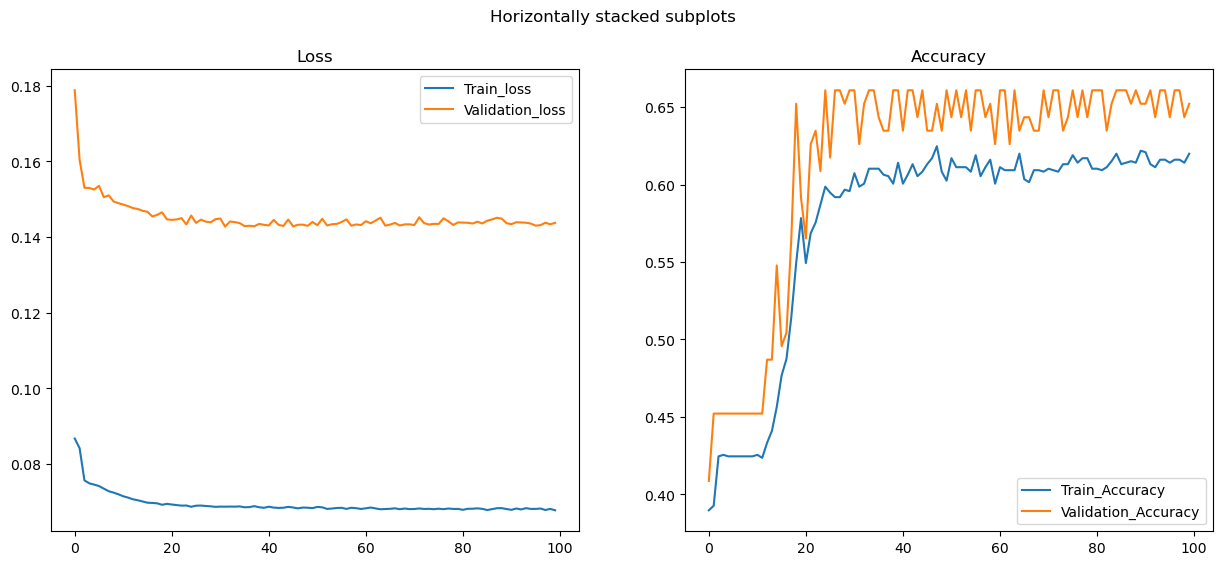

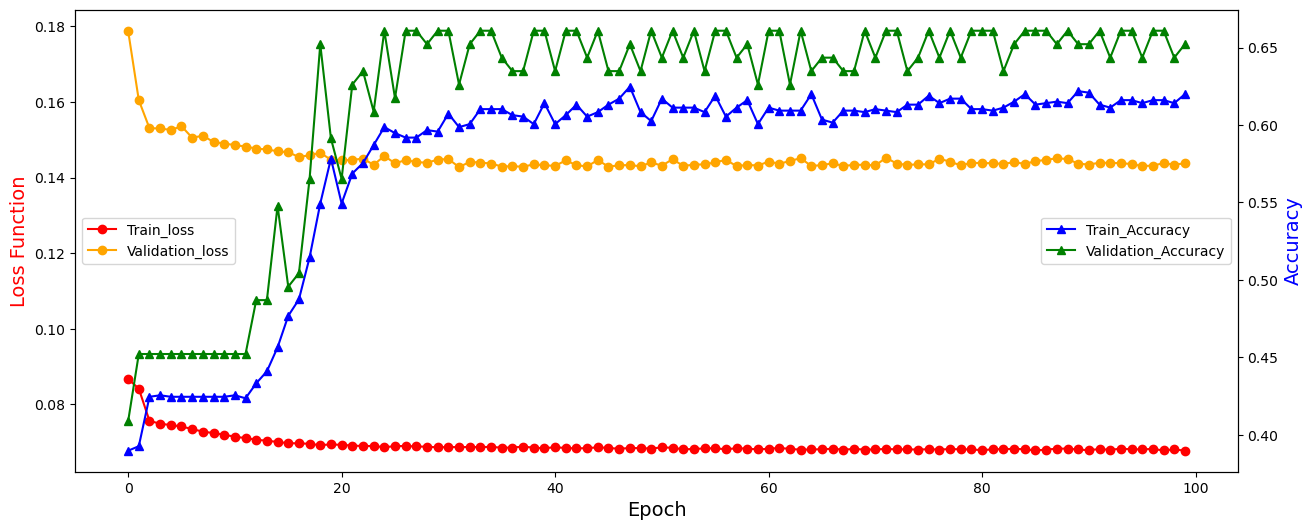

Current time: 21.300 minutes. Time expected till completion: 85.200 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.06802766875326056
Val loss:  0.14505311820818031
train accuracy:  0.6121856866537717
Val accuracy:  0.6695652173913044
Current time: 21.463 minutes. Time expected till completion: 84.788 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06812114572617256
Val loss:  0.14285909144774728
train accuracy:  0.6063829787234043
Val accuracy:  0.6608695652173913
Current time: 21.641 minutes. Time expected till completion: 84.443 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06814363714112996
Val loss:  0.14301266462906548
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 21.818 minutes. Time expected till completion: 84.094 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06789846507908066
Val loss:  0.14335832854975825
train accuracy:  0.6102514506769826
Val accuracy:  0.6521739130434783
Current time: 21.998 minutes. Time expected till completion: 83.763 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06805829539520367
Val loss:  0.14362436273823614
train accuracy:  0.6083172147001934
Val accuracy:  0.6521739130434783
Current time: 22.175 minutes. Time expected till completion: 83.419 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06783949619796797
Val loss:  0.14376094237617823
train accuracy:  0.6092843326885881
Val accuracy:  0.6695652173913044
Current time: 22.352 minutes. Time expected till completion: 83.083 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06791754738505158
Val loss:  0.14335907283036606
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 22.530 minutes. Time expected till completion: 82.750 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.0682096287636969
Val loss:  0.14370159221732098
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 22.709 minutes. Time expected till completion: 82.427 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 20.22it/s]


train loss:  0.06778972660780413
Val loss:  0.1436498776726101
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 22.891 minutes. Time expected till completion: 82.114 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06804113640545416
Val loss:  0.14496522675389828
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 23.069 minutes. Time expected till completion: 81.791 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.0680334836071649
Val loss:  0.14441471825475277
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 23.248 minutes. Time expected till completion: 81.474 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.0683933346598937
Val loss:  0.1440064787864685
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 23.432 minutes. Time expected till completion: 81.174 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.0679236335726725
Val loss:  0.14328087153642075
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 23.613 minutes. Time expected till completion: 80.871 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06812363130903336
Val loss:  0.14396328718765922
train accuracy:  0.6141199226305609
Val accuracy:  0.6695652173913044
Current time: 23.795 minutes. Time expected till completion: 80.568 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.0678762183659773
Val loss:  0.1439422244610994
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 23.972 minutes. Time expected till completion: 80.253 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06790371916510841
Val loss:  0.1442700251289036
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 24.150 minutes. Time expected till completion: 79.944 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06811053408183719
Val loss:  0.14363130745680436
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 24.326 minutes. Time expected till completion: 79.631 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06771795581341712
Val loss:  0.14344841190006422
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 24.501 minutes. Time expected till completion: 79.318 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06785310484915684
Val loss:  0.1429554291393446
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 24.677 minutes. Time expected till completion: 79.009 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06808602377570575
Val loss:  0.14378514186195704
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 24.856 minutes. Time expected till completion: 78.711 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06799565540983322
Val loss:  0.14335836742235267
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 25.039 minutes. Time expected till completion: 78.427 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06818054331109878
Val loss:  0.142857129159181
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 25.217 minutes. Time expected till completion: 78.131 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06791961809883265
Val loss:  0.14243109640867813
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 25.395 minutes. Time expected till completion: 77.838 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06782859200665753
Val loss:  0.14301113356714662
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 25.575 minutes. Time expected till completion: 77.550 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.0681063970352741
Val loss:  0.144278085231781
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 25.752 minutes. Time expected till completion: 77.257 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06793497096408498
Val loss:  0.14471110468325407
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 25.932 minutes. Time expected till completion: 76.973 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06781556989053693
Val loss:  0.1431810016217439
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 26.111 minutes. Time expected till completion: 76.689 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06792694549265406
Val loss:  0.14267887913662455
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 26.289 minutes. Time expected till completion: 76.403 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06809103021999853
Val loss:  0.14413320810898492
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 26.468 minutes. Time expected till completion: 76.121 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.0679196874454358
Val loss:  0.14303686463314555
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 26.647 minutes. Time expected till completion: 75.842 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06806448476688083
Val loss:  0.14275310816972153
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 26.827 minutes. Time expected till completion: 75.567 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06780477562771545
Val loss:  0.14321259001026984
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 27.008 minutes. Time expected till completion: 75.295 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.0679727632487535
Val loss:  0.14330961341443268
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 27.188 minutes. Time expected till completion: 75.021 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.0680639823354651
Val loss:  0.14410835608192113
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 27.366 minutes. Time expected till completion: 74.745 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06766479728992027
Val loss:  0.14424905465996785
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 27.547 minutes. Time expected till completion: 74.479 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06802833985313918
Val loss:  0.14366447925567627
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 27.728 minutes. Time expected till completion: 74.213 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06794684935123363
Val loss:  0.14329674865888511
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 27.910 minutes. Time expected till completion: 73.950 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06796453896066898
Val loss:  0.14318427469419395
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 28.088 minutes. Time expected till completion: 73.681 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06789998851385061
Val loss:  0.1448060813157455
train accuracy:  0.620889748549323
Val accuracy:  0.6347826086956522
Current time: 28.267 minutes. Time expected till completion: 73.412 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06825458663344613
Val loss:  0.1424029360646787
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 28.443 minutes. Time expected till completion: 73.138 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06803899968846393
Val loss:  0.14369716540626856
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 28.621 minutes. Time expected till completion: 72.871 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.06809937089278112
Val loss:  0.1436336698739425
train accuracy:  0.6141199226305609
Val accuracy:  0.6695652173913044
Current time: 28.800 minutes. Time expected till completion: 72.607 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06809553555870425
Val loss:  0.14288807018943456
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 28.975 minutes. Time expected till completion: 72.336 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.0679065865289773
Val loss:  0.14279160499572754
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 29.153 minutes. Time expected till completion: 72.073 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06790376770196616
Val loss:  0.14296475182408871
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 29.333 minutes. Time expected till completion: 71.816 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06768211935659442
Val loss:  0.14281834104786748
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 29.509 minutes. Time expected till completion: 71.550 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06769533510134344
Val loss:  0.14248927313348522
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 29.685 minutes. Time expected till completion: 71.285 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06801469165766955
Val loss:  0.14290801442187764
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 29.864 minutes. Time expected till completion: 71.029 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 29.67it/s]


train loss:  0.06807930072917237
Val loss:  0.14355493887611057
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 30.040 minutes. Time expected till completion: 70.765 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06770216565528737
Val loss:  0.14367518010346786
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 30.218 minutes. Time expected till completion: 70.509 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.0680525262535656
Val loss:  0.1445404332617055
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 30.396 minutes. Time expected till completion: 70.252 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06782141189510633
Val loss:  0.14354882654936418
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 30.570 minutes. Time expected till completion: 69.989 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06801033509999686
Val loss:  0.1439118478609168
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 30.749 minutes. Time expected till completion: 69.737 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06810067902450635
Val loss:  0.14595047805620276
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 30.931 minutes. Time expected till completion: 69.495 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.0676019660969998
Val loss:  0.14357298508934352
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 31.106 minutes. Time expected till completion: 69.236 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06779072639789988
Val loss:  0.14530097090679667
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 31.285 minutes. Time expected till completion: 68.987 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06793906016552702
Val loss:  0.1430007701334746
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 31.465 minutes. Time expected till completion: 68.742 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06792662671732949
Val loss:  0.14285437749779742
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 31.640 minutes. Time expected till completion: 68.487 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06770044547907389
Val loss:  0.14354008021561995
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 31.819 minutes. Time expected till completion: 68.241 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06771772287108681
Val loss:  0.14348839158597199
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 31.998 minutes. Time expected till completion: 67.995 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06783963247009588
Val loss:  0.14374923498734185
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 32.174 minutes. Time expected till completion: 67.745 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06790965184482892
Val loss:  0.14316987473031748
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 32.354 minutes. Time expected till completion: 67.504 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06795590066817558
Val loss:  0.142884958308676
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 32.535 minutes. Time expected till completion: 67.265 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06792613362435908
Val loss:  0.14439672490824823
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 32.715 minutes. Time expected till completion: 67.027 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06796097847663687
Val loss:  0.14306631606558096
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 32.899 minutes. Time expected till completion: 66.794 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06781355976136096
Val loss:  0.14468807655832042
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 33.082 minutes. Time expected till completion: 66.562 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06803266724258142
Val loss:  0.14534072202184925
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 33.262 minutes. Time expected till completion: 66.325 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06842019687077062
Val loss:  0.14360489534295123
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 33.457 minutes. Time expected till completion: 66.117 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06806649472312264
Val loss:  0.14436425592588342
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 33.637 minutes. Time expected till completion: 65.881 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.0679716002664437
Val loss:  0.14350217839945917
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 33.817 minutes. Time expected till completion: 65.644 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.0681218107157104
Val loss:  0.14379250536794247
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 33.999 minutes. Time expected till completion: 65.413 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06761428362165706
Val loss:  0.14419026478477145
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 34.180 minutes. Time expected till completion: 65.181 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 28.16it/s]


train loss:  0.06785204407094295
Val loss:  0.14291922527810802
train accuracy:  0.6160541586073501
Val accuracy:  0.6521739130434783
Current time: 34.360 minutes. Time expected till completion: 64.947 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06787823437491515
Val loss:  0.14367300997609678
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 34.541 minutes. Time expected till completion: 64.715 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06782585203762903
Val loss:  0.14280840521273405
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 34.721 minutes. Time expected till completion: 64.482 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06780070060687554
Val loss:  0.14280697366465692
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 34.915 minutes. Time expected till completion: 64.276 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06787827974131305
Val loss:  0.14361407860465672
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 35.091 minutes. Time expected till completion: 64.037 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06759469698199451
Val loss:  0.1435879831728728
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 35.268 minutes. Time expected till completion: 63.800 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06766191222912107
Val loss:  0.14406399726867675
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 35.447 minutes. Time expected till completion: 63.566 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06755798467123302
Val loss:  0.14339543943819794
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 35.623 minutes. Time expected till completion: 63.329 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06795641722254873
Val loss:  0.14374496522157088
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 35.799 minutes. Time expected till completion: 63.094 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06765757625061493
Val loss:  0.14372719422630642
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 35.978 minutes. Time expected till completion: 62.862 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06751726120998597
Val loss:  0.14366840901582137
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 36.154 minutes. Time expected till completion: 62.627 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.0675484595146585
Val loss:  0.1432184908701026
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 36.331 minutes. Time expected till completion: 62.394 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 29.04it/s]


train loss:  0.06797139603118602
Val loss:  0.14354770701864492
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 36.510 minutes. Time expected till completion: 62.166 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06791750028931196
Val loss:  0.14341447975324548
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 36.687 minutes. Time expected till completion: 61.934 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06756213849241083
Val loss:  0.1442483487336532
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 36.865 minutes. Time expected till completion: 61.705 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06785320296047735
Val loss:  0.14340061052985814
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 37.044 minutes. Time expected till completion: 61.477 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06754449159771607
Val loss:  0.14337919587674347
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 37.217 minutes. Time expected till completion: 61.241 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06766637127911329
Val loss:  0.14429995132529216
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 37.393 minutes. Time expected till completion: 61.010 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.06747589374188068
Val loss:  0.14373712280522222
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 37.569 minutes. Time expected till completion: 60.780 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06779750126704026
Val loss:  0.14368272967960524
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 37.748 minutes. Time expected till completion: 60.554 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06760948573597626
Val loss:  0.14353812984798264
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 37.930 minutes. Time expected till completion: 60.334 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06750026068558315
Val loss:  0.14336539092271225
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 38.103 minutes. Time expected till completion: 60.100 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.0677822819646138
Val loss:  0.14474551055742346
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 38.277 minutes. Time expected till completion: 59.869 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.0677393181411625
Val loss:  0.14393085915109385
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 38.458 minutes. Time expected till completion: 59.648 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06787645609281971
Val loss:  0.14565862987352454
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 38.632 minutes. Time expected till completion: 59.418 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.0680283888511547
Val loss:  0.1438299033952796
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 38.805 minutes. Time expected till completion: 59.188 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06787962205635971
Val loss:  0.1442573034245035
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 38.988 minutes. Time expected till completion: 58.972 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06766645520983167
Val loss:  0.14427429904108463
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Saving model checkpoint


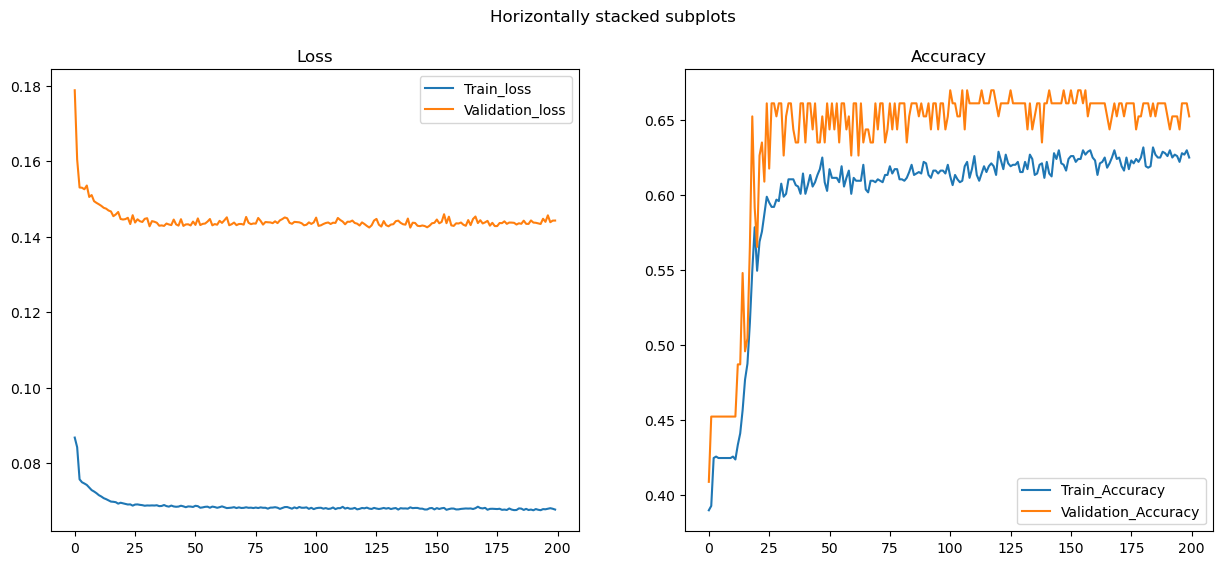

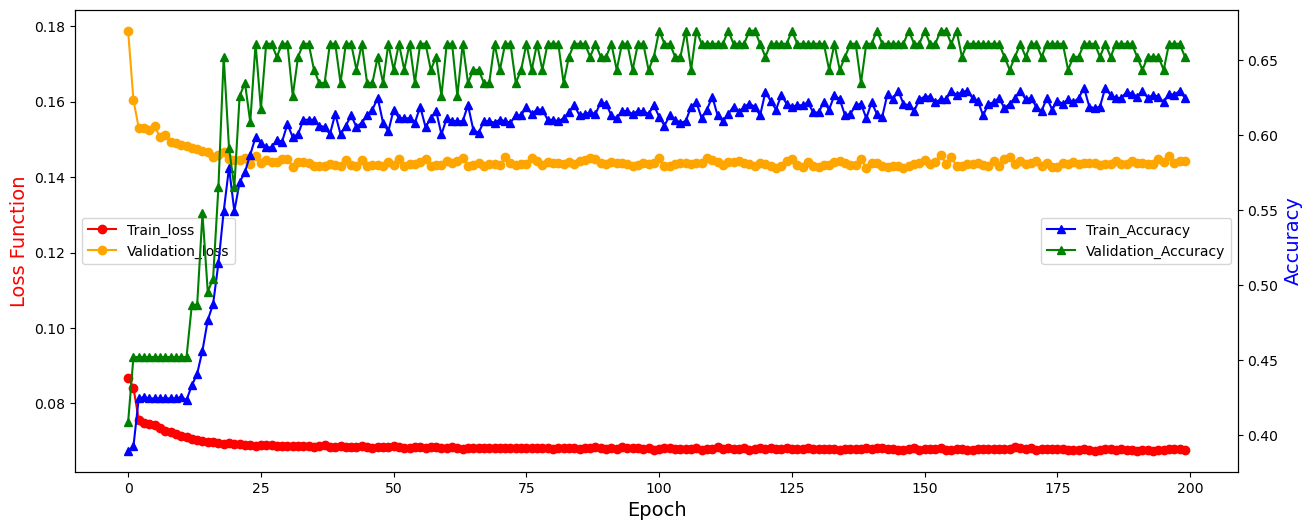

Current time: 39.182 minutes. Time expected till completion: 58.772 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06782128859304137
Val loss:  0.14336925330369368
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 39.356 minutes. Time expected till completion: 58.545 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06800082164530136
Val loss:  0.1433612496956535
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 39.530 minutes. Time expected till completion: 58.316 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.0676646214735116
Val loss:  0.14451848527659542
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 39.706 minutes. Time expected till completion: 58.091 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06847327411520643
Val loss:  0.14399122673532236
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 39.879 minutes. Time expected till completion: 57.863 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


train loss:  0.06787940496632855
Val loss:  0.14464353841284047
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 40.055 minutes. Time expected till completion: 57.640 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06803232050956563
Val loss:  0.14330488806185515
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 40.229 minutes. Time expected till completion: 57.414 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06797539657504231
Val loss:  0.14358571404996126
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 40.404 minutes. Time expected till completion: 57.190 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06770078218190767
Val loss:  0.1441790933194368
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 40.579 minutes. Time expected till completion: 56.966 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06784450598565477
Val loss:  0.1432350023933079
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 40.752 minutes. Time expected till completion: 56.741 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06728473467107438
Val loss:  0.1438693855119788
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 40.934 minutes. Time expected till completion: 56.527 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06808124912084879
Val loss:  0.14422709268072378
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 41.110 minutes. Time expected till completion: 56.307 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06787495917462288
Val loss:  0.14393635521764342
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 41.284 minutes. Time expected till completion: 56.084 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06743912078886936
Val loss:  0.14339220212853473
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 41.460 minutes. Time expected till completion: 55.864 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06782481604664653
Val loss:  0.14370738423388937
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 41.637 minutes. Time expected till completion: 55.646 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06753685707280438
Val loss:  0.14383785102678381
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 41.813 minutes. Time expected till completion: 55.427 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06791637679363818
Val loss:  0.14336767507636028
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 41.989 minutes. Time expected till completion: 55.207 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06794824717814964
Val loss:  0.14441808721293573
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 42.167 minutes. Time expected till completion: 54.992 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06790694530974044
Val loss:  0.14343771260717642
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 42.340 minutes. Time expected till completion: 54.771 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.0678219492592249
Val loss:  0.14400934240092403
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 42.516 minutes. Time expected till completion: 54.553 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.0681555484434161
Val loss:  0.1447729416515516
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 42.694 minutes. Time expected till completion: 54.338 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.0679614761235405
Val loss:  0.14381083405536155
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 42.870 minutes. Time expected till completion: 54.121 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.0677714909875416
Val loss:  0.1442586909169736
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 43.049 minutes. Time expected till completion: 53.908 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06781363187491087
Val loss:  0.14422059318293695
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 43.223 minutes. Time expected till completion: 53.690 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.0673569307682362
Val loss:  0.14472095448037853
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 43.399 minutes. Time expected till completion: 53.474 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06779752582369275
Val loss:  0.14336306841477103
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 43.578 minutes. Time expected till completion: 53.262 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06775497104720406
Val loss:  0.14313074091206426
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 43.756 minutes. Time expected till completion: 53.049 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06802214736864691
Val loss:  0.14434020260105962
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 43.931 minutes. Time expected till completion: 52.833 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06787097805703862
Val loss:  0.14483890066976132
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 44.107 minutes. Time expected till completion: 52.619 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06770227160629036
Val loss:  0.1462957060855368
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 44.285 minutes. Time expected till completion: 52.407 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06792679440583205
Val loss:  0.1434263913527779
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 44.460 minutes. Time expected till completion: 52.192 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06812731134822336
Val loss:  0.1434212627618209
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 44.636 minutes. Time expected till completion: 51.979 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06753471551365732
Val loss:  0.14482626085696013
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 44.811 minutes. Time expected till completion: 51.765 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.0673404541190865
Val loss:  0.14403626400491465
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 44.989 minutes. Time expected till completion: 51.554 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06786709043919695
Val loss:  0.14544649849767272
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 45.167 minutes. Time expected till completion: 51.344 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06759222356217051
Val loss:  0.14415040949116584
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 45.345 minutes. Time expected till completion: 51.133 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06816108464272387
Val loss:  0.14515574600385583
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 45.521 minutes. Time expected till completion: 50.922 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06789043868533416
Val loss:  0.14441500591195147
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 45.701 minutes. Time expected till completion: 50.714 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06832003898961862
Val loss:  0.14299949200257012
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 45.878 minutes. Time expected till completion: 50.505 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06804353598238652
Val loss:  0.14232225107110064
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 46.053 minutes. Time expected till completion: 50.292 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06852142463800294
Val loss:  0.14324295209801716
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 46.231 minutes. Time expected till completion: 50.084 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06779466612657219
Val loss:  0.14379101991653442
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 46.408 minutes. Time expected till completion: 49.874 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06761790221157112
Val loss:  0.14338728966920272
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 46.584 minutes. Time expected till completion: 49.663 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06772177823507579
Val loss:  0.1433347681294317
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 46.769 minutes. Time expected till completion: 49.464 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 32.28it/s]


train loss:  0.06746836355391969
Val loss:  0.14429617446401846
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 46.951 minutes. Time expected till completion: 49.260 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06774562850911567
Val loss:  0.14388494491577147
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 47.124 minutes. Time expected till completion: 49.047 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06758298841620322
Val loss:  0.14425962489584218
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 47.302 minutes. Time expected till completion: 48.840 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06767793140973989
Val loss:  0.14372029667315275
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 47.480 minutes. Time expected till completion: 48.634 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.0676755935703071
Val loss:  0.14311834262764972
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 47.657 minutes. Time expected till completion: 48.426 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06763911270311308
Val loss:  0.1441079046415246
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 47.840 minutes. Time expected till completion: 48.224 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06773415697843009
Val loss:  0.14429679383402286
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 48.015 minutes. Time expected till completion: 48.015 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06753619946179122
Val loss:  0.14298076940619428
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 48.190 minutes. Time expected till completion: 47.806 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06763817372820133
Val loss:  0.14361771552459054
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 48.367 minutes. Time expected till completion: 47.599 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06770071929151361
Val loss:  0.14329190772512684
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 48.542 minutes. Time expected till completion: 47.391 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06745604089888198
Val loss:  0.14473086077234018
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 48.718 minutes. Time expected till completion: 47.184 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06746842915361578
Val loss:  0.1434618001398833
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 48.895 minutes. Time expected till completion: 46.978 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06795926112501488
Val loss:  0.14400124757186225
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 49.072 minutes. Time expected till completion: 46.772 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06757448973923172
Val loss:  0.1435634291690329
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 49.246 minutes. Time expected till completion: 46.564 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06740761333554118
Val loss:  0.14368542173634405
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 49.425 minutes. Time expected till completion: 46.360 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06780645499146423
Val loss:  0.14376840073129404
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 49.603 minutes. Time expected till completion: 46.156 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06766944697101526
Val loss:  0.1437536446944527
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 49.777 minutes. Time expected till completion: 45.948 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06764509830069035
Val loss:  0.14476070248562356
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 49.956 minutes. Time expected till completion: 45.745 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06788356311086068
Val loss:  0.14410469946653948
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 50.133 minutes. Time expected till completion: 45.541 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.06786540358163402
Val loss:  0.14378238916397096
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 50.307 minutes. Time expected till completion: 45.334 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06750414542118861
Val loss:  0.145636450726053
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 50.485 minutes. Time expected till completion: 45.131 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06755758865197807
Val loss:  0.1447109668151192
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 50.664 minutes. Time expected till completion: 44.929 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06744096674587095
Val loss:  0.1431731669799141
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 50.838 minutes. Time expected till completion: 44.722 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06787666315266888
Val loss:  0.14312899734662926
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 51.017 minutes. Time expected till completion: 44.520 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06717395793999648
Val loss:  0.1437211705290753
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 51.194 minutes. Time expected till completion: 44.317 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06735074946682043
Val loss:  0.14646972780642303
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 51.368 minutes. Time expected till completion: 44.111 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06769700702892281
Val loss:  0.14329008848770805
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 51.543 minutes. Time expected till completion: 43.907 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06776930636778561
Val loss:  0.14306862976240076
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 51.720 minutes. Time expected till completion: 43.705 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06752929512260039
Val loss:  0.14334675695585167
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 51.893 minutes. Time expected till completion: 43.499 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06767679920971278
Val loss:  0.14436830800512562
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 52.069 minutes. Time expected till completion: 43.295 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06781931489533105
Val loss:  0.1446866522664609
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 52.245 minutes. Time expected till completion: 43.093 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06772223962344791
Val loss:  0.1437038048453953
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 52.419 minutes. Time expected till completion: 42.888 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06720074763381043
Val loss:  0.14246875721475352
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 52.594 minutes. Time expected till completion: 42.685 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06784986608033024
Val loss:  0.14343811221744704
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 52.768 minutes. Time expected till completion: 42.481 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06772549972082245
Val loss:  0.14340031147003174
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 52.944 minutes. Time expected till completion: 42.279 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06788565175215096
Val loss:  0.14399401001308276
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 53.119 minutes. Time expected till completion: 42.076 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06721603835805011
Val loss:  0.1436915283617766
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 53.291 minutes. Time expected till completion: 41.871 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06773586798913243
Val loss:  0.14329396175301592
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 53.465 minutes. Time expected till completion: 41.668 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06784954753558456
Val loss:  0.1441227824791618
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 53.642 minutes. Time expected till completion: 41.468 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06730442236193836
Val loss:  0.14371185717375382
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 53.817 minutes. Time expected till completion: 41.266 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06785895757564493
Val loss:  0.14407676302868386
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 53.994 minutes. Time expected till completion: 41.066 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06774840779184603
Val loss:  0.14295195652090986
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 54.169 minutes. Time expected till completion: 40.864 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06745397998470402
Val loss:  0.1431260876033617
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 54.342 minutes. Time expected till completion: 40.662 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 32.28it/s]


train loss:  0.06748883014029645
Val loss:  0.14333149816678917
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 54.518 minutes. Time expected till completion: 40.461 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06744088719615161
Val loss:  0.14370759570080302
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 54.695 minutes. Time expected till completion: 40.262 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06743433771788267
Val loss:  0.1444603733394457
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 54.871 minutes. Time expected till completion: 40.061 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06753301701186012
Val loss:  0.1434712757234988
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 55.047 minutes. Time expected till completion: 39.861 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06757907554997236
Val loss:  0.14351736566294795
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 55.223 minutes. Time expected till completion: 39.662 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.0674886834921182
Val loss:  0.1427658215813015
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 55.396 minutes. Time expected till completion: 39.460 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06781616818512892
Val loss:  0.1433847427368164
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 55.575 minutes. Time expected till completion: 39.263 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06763218905293965
Val loss:  0.14246205246966817
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 55.750 minutes. Time expected till completion: 39.063 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.0674834374187071
Val loss:  0.14285639472629713
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 55.924 minutes. Time expected till completion: 38.862 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06819338355811468
Val loss:  0.14390580913294918
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 56.100 minutes. Time expected till completion: 38.664 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06816177701350568
Val loss:  0.14310895152713943
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 56.277 minutes. Time expected till completion: 38.466 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06785306553545496
Val loss:  0.14287014940510626
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 56.450 minutes. Time expected till completion: 38.265 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06740239158820369
Val loss:  0.1433147228282431
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 56.626 minutes. Time expected till completion: 38.066 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06748910360686784
Val loss:  0.14290541151295538
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Saving model checkpoint


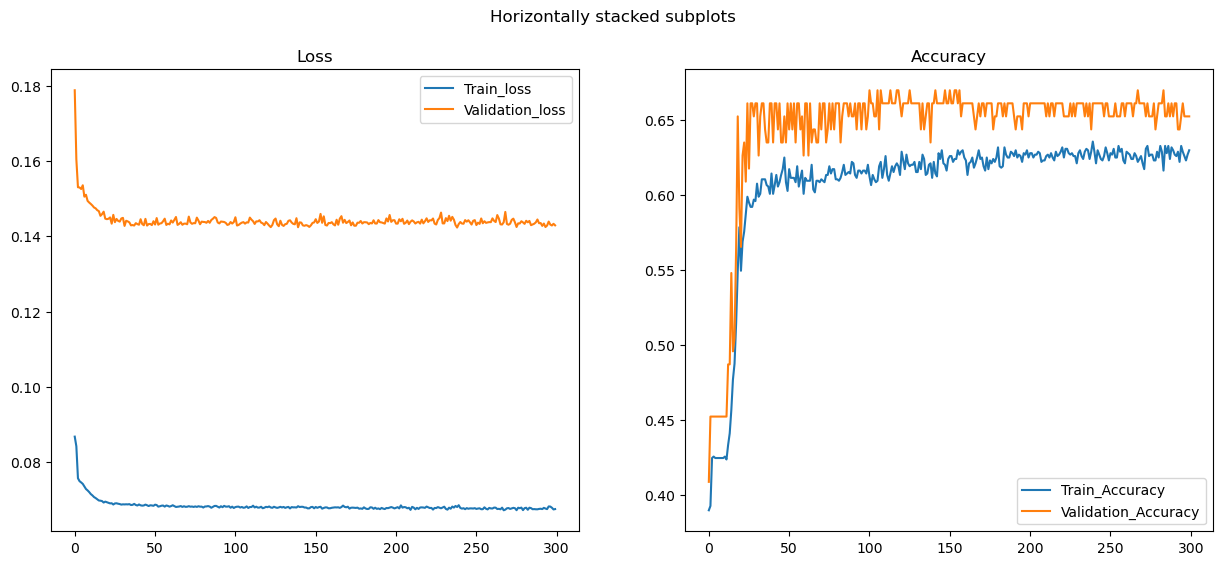

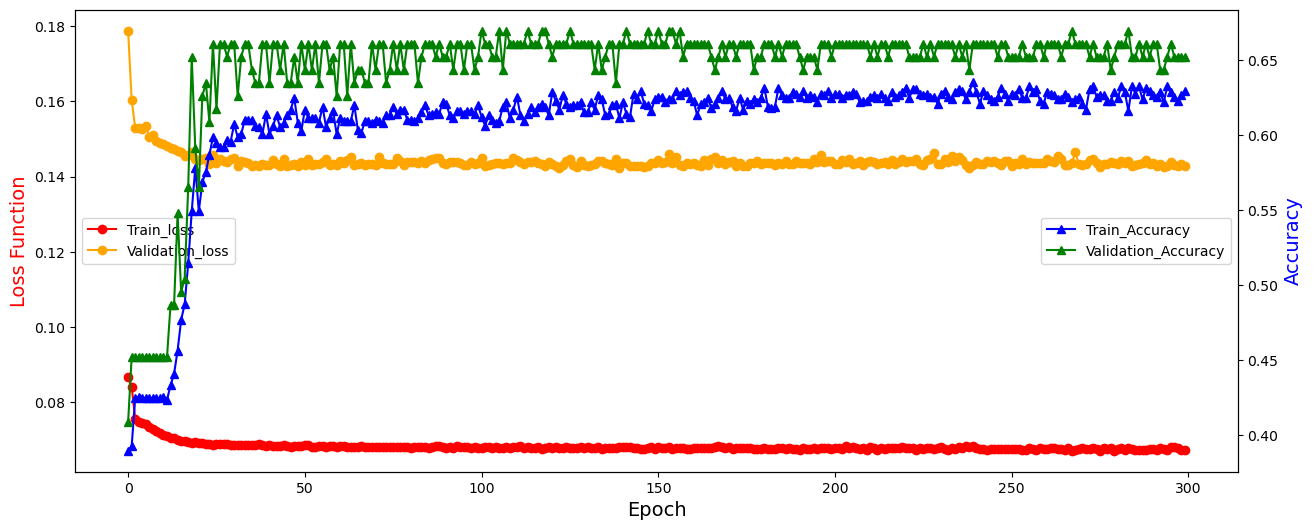

Current time: 56.822 minutes. Time expected till completion: 37.881 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06794971844444422
Val loss:  0.14362924876420394
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 56.995 minutes. Time expected till completion: 37.681 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06747805668722039
Val loss:  0.14272365881049115
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 57.170 minutes. Time expected till completion: 37.482 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06772761401401498
Val loss:  0.14368960650070853
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 57.346 minutes. Time expected till completion: 37.284 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06772789635787388
Val loss:  0.14390573501586915
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 57.519 minutes. Time expected till completion: 37.085 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06742156802800915
Val loss:  0.14383794483931167
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 57.695 minutes. Time expected till completion: 36.887 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06758798944189194
Val loss:  0.14377765862838082
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 57.876 minutes. Time expected till completion: 36.692 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06725051560992198
Val loss:  0.14266822752745256
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 58.047 minutes. Time expected till completion: 36.492 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06749713121115354
Val loss:  0.14384664348934006
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 58.223 minutes. Time expected till completion: 36.295 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06747817975870646
Val loss:  0.14373203360516093
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 58.397 minutes. Time expected till completion: 36.096 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.06752197914243437
Val loss:  0.143882039318914
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 58.571 minutes. Time expected till completion: 35.899 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06752466936406591
Val loss:  0.14292803069819573
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 58.747 minutes. Time expected till completion: 35.701 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06722937129452335
Val loss:  0.1431980039762414
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 58.924 minutes. Time expected till completion: 35.505 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06738625048899327
Val loss:  0.14252912065257198
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 59.096 minutes. Time expected till completion: 35.307 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06739744745785771
Val loss:  0.1424855076748392
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 59.271 minutes. Time expected till completion: 35.109 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06727988271464232
Val loss:  0.14238687390866486
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 59.447 minutes. Time expected till completion: 34.913 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06798974878552803
Val loss:  0.14255017456801042
train accuracy:  0.6315280464216635
Val accuracy:  0.6434782608695652
Current time: 59.622 minutes. Time expected till completion: 34.717 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06774344123770236
Val loss:  0.14366380961044975
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 59.797 minutes. Time expected till completion: 34.520 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06746937066489539
Val loss:  0.14336225727330085
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 59.972 minutes. Time expected till completion: 34.324 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06753358394772217
Val loss:  0.14328641735989114
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 60.145 minutes. Time expected till completion: 34.126 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06734414338143237
Val loss:  0.14373691082000734
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 60.321 minutes. Time expected till completion: 33.931 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06793251985276921
Val loss:  0.14301212870556376
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 60.495 minutes. Time expected till completion: 33.734 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06742705136710486
Val loss:  0.14323021380797676
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 60.668 minutes. Time expected till completion: 33.537 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06748780844520554
Val loss:  0.14234526934831038
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 60.845 minutes. Time expected till completion: 33.342 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06763777269385539
Val loss:  0.14347009917964107
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 61.019 minutes. Time expected till completion: 33.146 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06729622701150537
Val loss:  0.143259116359379
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 61.194 minutes. Time expected till completion: 32.950 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06724534931680912
Val loss:  0.14323240881380828
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 61.369 minutes. Time expected till completion: 32.755 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.0670561603120955
Val loss:  0.14364902973175048
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 61.543 minutes. Time expected till completion: 32.560 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06789656995112937
Val loss:  0.14443068400673245
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 61.720 minutes. Time expected till completion: 32.365 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06736081308276326
Val loss:  0.14245483667954154
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 61.897 minutes. Time expected till completion: 32.171 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06738774498611169
Val loss:  0.14265085458755494
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 62.071 minutes. Time expected till completion: 31.976 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06755272758767959
Val loss:  0.14270974604979805
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 62.248 minutes. Time expected till completion: 31.782 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06730017383047875
Val loss:  0.14371866091437963
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 62.425 minutes. Time expected till completion: 31.588 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.0672917380439013
Val loss:  0.14304451838783597
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 62.603 minutes. Time expected till completion: 31.395 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06735268661777563
Val loss:  0.14281613982242086
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 62.781 minutes. Time expected till completion: 31.203 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06714816965033053
Val loss:  0.14335803208143816
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 62.958 minutes. Time expected till completion: 31.009 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06771023856832627
Val loss:  0.14249065751614778
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 63.133 minutes. Time expected till completion: 30.815 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


train loss:  0.0673155119963264
Val loss:  0.14338170860124672
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 63.311 minutes. Time expected till completion: 30.622 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06721557685438853
Val loss:  0.14323749697726706
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 63.488 minutes. Time expected till completion: 30.429 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06745497937128668
Val loss:  0.1429505529611007
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 63.663 minutes. Time expected till completion: 30.235 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06733084128488655
Val loss:  0.1430015019748522
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 63.838 minutes. Time expected till completion: 30.042 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06756089751678925
Val loss:  0.14358075753502222
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 64.016 minutes. Time expected till completion: 29.849 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06740084405793904
Val loss:  0.14363948262256124
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 64.191 minutes. Time expected till completion: 29.655 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.0671111646773045
Val loss:  0.14347891081934389
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 64.367 minutes. Time expected till completion: 29.462 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06738795193067142
Val loss:  0.14248949755793033
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 64.542 minutes. Time expected till completion: 29.269 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06718705534012683
Val loss:  0.14220722084460052
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 64.717 minutes. Time expected till completion: 29.076 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06725692870077359
Val loss:  0.1437668484190236
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 64.893 minutes. Time expected till completion: 28.883 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06796672640501646
Val loss:  0.1424317173335863
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 65.070 minutes. Time expected till completion: 28.691 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06732528542872784
Val loss:  0.14551639556884766
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 65.242 minutes. Time expected till completion: 28.497 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06728513812649872
Val loss:  0.14402810335159302
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 65.421 minutes. Time expected till completion: 28.306 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06732431526802034
Val loss:  0.14297506601914114
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 65.598 minutes. Time expected till completion: 28.113 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06747788836462586
Val loss:  0.1437436844991601
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 65.771 minutes. Time expected till completion: 27.920 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06728635748534875
Val loss:  0.1430296752763831
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 65.949 minutes. Time expected till completion: 27.728 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


train loss:  0.0673391353230873
Val loss:  0.14389856794606085
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 66.128 minutes. Time expected till completion: 27.538 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06722893048531774
Val loss:  0.14247452746266903
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 66.302 minutes. Time expected till completion: 27.345 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06700495796231283
Val loss:  0.14322728747906893
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 66.476 minutes. Time expected till completion: 27.152 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06745761811617956
Val loss:  0.14366424498350724
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 66.653 minutes. Time expected till completion: 26.961 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06742208763755267
Val loss:  0.14367538431416388
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 66.827 minutes. Time expected till completion: 26.768 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06726532488542553
Val loss:  0.14335784756618997
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 67.005 minutes. Time expected till completion: 26.577 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06731820671424645
Val loss:  0.14390458853348442
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 67.179 minutes. Time expected till completion: 26.385 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06727578590409668
Val loss:  0.1429085093995799
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 67.351 minutes. Time expected till completion: 26.192 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06717357408377833
Val loss:  0.14272128395412279
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 67.527 minutes. Time expected till completion: 26.001 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06718878537358813
Val loss:  0.14412087668543277
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 67.702 minutes. Time expected till completion: 25.809 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06743608193194613
Val loss:  0.1429151659426482
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 67.876 minutes. Time expected till completion: 25.617 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06742176943867534
Val loss:  0.1436412292978038
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 68.054 minutes. Time expected till completion: 25.427 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06760886132832422
Val loss:  0.14402259225430697
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 68.228 minutes. Time expected till completion: 25.235 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06723446328358677
Val loss:  0.1437942826229593
train accuracy:  0.6276595744680851
Val accuracy:  0.6347826086956522
Current time: 68.401 minutes. Time expected till completion: 25.043 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06759167305505483
Val loss:  0.1438504441924717
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 68.577 minutes. Time expected till completion: 24.852 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06757721131959321
Val loss:  0.14334184501482092
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 68.752 minutes. Time expected till completion: 24.661 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06753552294330856
Val loss:  0.14438890063244364
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 68.926 minutes. Time expected till completion: 24.470 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06746071035211737
Val loss:  0.14380924079729163
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 69.103 minutes. Time expected till completion: 24.279 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 24.18it/s]


train loss:  0.06732097100934853
Val loss:  0.14279943238133969
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 69.282 minutes. Time expected till completion: 24.090 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06713905982399355
Val loss:  0.14388711815295013
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 69.473 minutes. Time expected till completion: 23.905 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06716025031281625
Val loss:  0.14379266344982644
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 69.649 minutes. Time expected till completion: 23.714 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06753280401460438
Val loss:  0.1436627429464589
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 69.822 minutes. Time expected till completion: 23.523 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.0670447135109966
Val loss:  0.14281124602193418
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 69.999 minutes. Time expected till completion: 23.333 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06714352867358889
Val loss:  0.1441919585932856
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 70.175 minutes. Time expected till completion: 23.143 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06734557400819642
Val loss:  0.14238787423009458
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 70.349 minutes. Time expected till completion: 22.952 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06724722761250096
Val loss:  0.14417094355044158
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 70.527 minutes. Time expected till completion: 22.763 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06747125576266468
Val loss:  0.14341075005738632
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 70.703 minutes. Time expected till completion: 22.573 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06757360362453202
Val loss:  0.14228608660075975
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 70.876 minutes. Time expected till completion: 22.382 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06783345549203441
Val loss:  0.14395830527595851
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 71.052 minutes. Time expected till completion: 22.192 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train loss:  0.06785922631534894
Val loss:  0.1435270236886066
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 71.227 minutes. Time expected till completion: 22.002 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06685612914179465
Val loss:  0.14450449528901474
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 71.400 minutes. Time expected till completion: 21.812 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


train loss:  0.06726405871905948
Val loss:  0.14306961246158767
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 71.575 minutes. Time expected till completion: 21.622 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06709073106370995
Val loss:  0.1434211404427238
train accuracy:  0.6363636363636364
Val accuracy:  0.6521739130434783
Current time: 71.749 minutes. Time expected till completion: 21.432 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06711409815967198
Val loss:  0.1436341467111007
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 71.923 minutes. Time expected till completion: 21.242 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06701008834276255
Val loss:  0.14286283047302908
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 72.098 minutes. Time expected till completion: 21.052 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06697206374985568
Val loss:  0.14337511684583581
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 72.271 minutes. Time expected till completion: 20.862 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


train loss:  0.06734825022216
Val loss:  0.14326171564019244
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 72.443 minutes. Time expected till completion: 20.671 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06750557552915017
Val loss:  0.14332140632297682
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 72.616 minutes. Time expected till completion: 20.482 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06711860787937673
Val loss:  0.14303816038629283
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 72.791 minutes. Time expected till completion: 20.292 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06750427938752755
Val loss:  0.14376190641651984
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 72.962 minutes. Time expected till completion: 20.102 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06752375517638555
Val loss:  0.14427959504334822
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 73.138 minutes. Time expected till completion: 19.913 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06741842679405581
Val loss:  0.14327351632325547
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 73.312 minutes. Time expected till completion: 19.723 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


train loss:  0.06707077019449821
Val loss:  0.144667503108149
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 73.484 minutes. Time expected till completion: 19.534 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


train loss:  0.06734439938165233
Val loss:  0.14379042076027912
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 73.657 minutes. Time expected till completion: 19.344 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06698992854160774
Val loss:  0.1440970037294471
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 73.829 minutes. Time expected till completion: 19.155 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06721162386742967
Val loss:  0.14363772143488346
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 74.002 minutes. Time expected till completion: 18.965 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


train loss:  0.06735185566907695
Val loss:  0.14579955287601637
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 74.175 minutes. Time expected till completion: 18.776 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06758192337227975
Val loss:  0.1420716897301052
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Saving model checkpoint


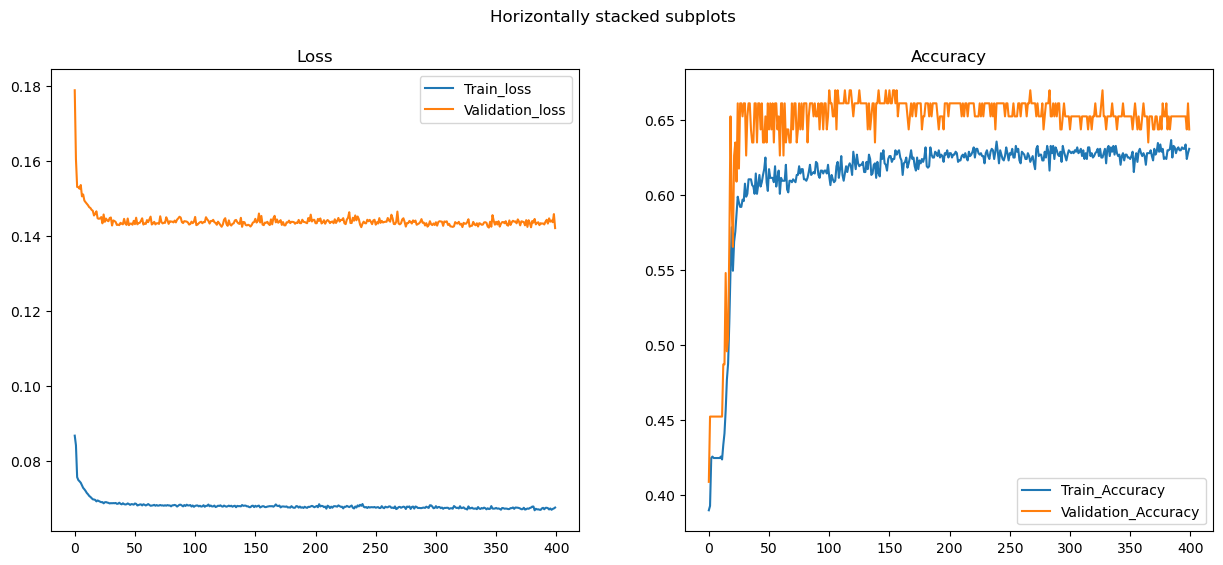

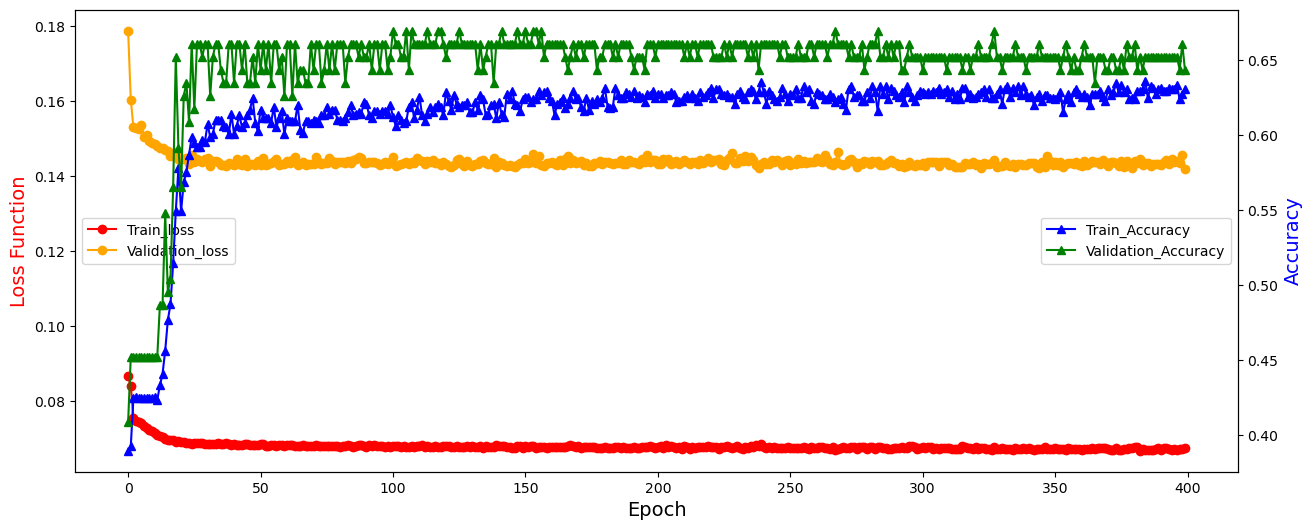

Current time: 74.363 minutes. Time expected till completion: 18.591 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06736564918689616
Val loss:  0.1432751458624135
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 74.537 minutes. Time expected till completion: 18.402 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.06730729572085854
Val loss:  0.14383178534715071
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 74.709 minutes. Time expected till completion: 18.213 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06712995754911545
Val loss:  0.14380016067753668
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 74.881 minutes. Time expected till completion: 18.024 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.06719710195087603
Val loss:  0.14372168934863547
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 75.054 minutes. Time expected till completion: 17.835 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06722839634930372
Val loss:  0.14364695445350978
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 75.228 minutes. Time expected till completion: 17.646 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 31.60it/s]


train loss:  0.06795550147846081
Val loss:  0.14292563510977704
train accuracy:  0.6141199226305609
Val accuracy:  0.6521739130434783
Current time: 75.399 minutes. Time expected till completion: 17.457 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06812394051533373
Val loss:  0.1421120902766352
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 75.573 minutes. Time expected till completion: 17.269 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06780590880770286
Val loss:  0.14454467503920845
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 75.752 minutes. Time expected till completion: 17.081 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06753225275810729
Val loss:  0.14443599659463632
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 75.927 minutes. Time expected till completion: 16.893 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


train loss:  0.06764495522648499
Val loss:  0.1449999653774759
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 76.105 minutes. Time expected till completion: 16.706 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06730428926027028
Val loss:  0.14461075637651527
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 76.280 minutes. Time expected till completion: 16.518 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


train loss:  0.06707845354449127
Val loss:  0.14375435580377993
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 76.453 minutes. Time expected till completion: 16.330 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06740987248992551
Val loss:  0.14308038224344669
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 76.630 minutes. Time expected till completion: 16.142 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


train loss:  0.0679054930085601
Val loss:  0.143946271357329
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 76.807 minutes. Time expected till completion: 15.955 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06729182185933023
Val loss:  0.1423278393952743
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 76.982 minutes. Time expected till completion: 15.767 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.0675531347323663
Val loss:  0.14307978567869767
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 77.159 minutes. Time expected till completion: 15.580 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06727717733244831
Val loss:  0.14266543077385943
train accuracy:  0.6363636363636364
Val accuracy:  0.6521739130434783
Current time: 77.340 minutes. Time expected till completion: 15.394 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06756896858519697
Val loss:  0.14229090213775636
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 77.514 minutes. Time expected till completion: 15.206 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06707990970786812
Val loss:  0.14289495737656302
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 77.694 minutes. Time expected till completion: 15.020 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06708513370334987
Val loss:  0.14287833441858705
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 77.878 minutes. Time expected till completion: 14.834 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06721801954957457
Val loss:  0.1436118799707164
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 78.053 minutes. Time expected till completion: 14.646 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


train loss:  0.06693109754667521
Val loss:  0.1432011604309082
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 78.231 minutes. Time expected till completion: 14.460 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06727194030925891
Val loss:  0.14311870181042216
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 78.408 minutes. Time expected till completion: 14.273 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06691773970768115
Val loss:  0.14201496995013693
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 78.584 minutes. Time expected till completion: 14.086 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.06706231913206886
Val loss:  0.1436059744461723
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 78.764 minutes. Time expected till completion: 13.899 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06711416450874949
Val loss:  0.14352254193762073
train accuracy:  0.6353965183752418
Val accuracy:  0.6434782608695652
Current time: 78.940 minutes. Time expected till completion: 13.713 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 32.48it/s]


train loss:  0.06752980764184284
Val loss:  0.1434003726295803
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 79.113 minutes. Time expected till completion: 13.525 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06710305412226074
Val loss:  0.1436790134595788
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 79.288 minutes. Time expected till completion: 13.338 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06702394694147534
Val loss:  0.14305404372837233
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 79.466 minutes. Time expected till completion: 13.152 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06716048233283096
Val loss:  0.14316490214803945
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 79.640 minutes. Time expected till completion: 12.965 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.0669351023562411
Val loss:  0.14653158913487974
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 79.819 minutes. Time expected till completion: 12.779 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 30.76it/s]


train loss:  0.06742985186309372
Val loss:  0.14248926328576128
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 79.998 minutes. Time expected till completion: 12.592 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06706288013052433
Val loss:  0.14352316286252892
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 80.172 minutes. Time expected till completion: 12.405 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06735649082370146
Val loss:  0.14251236811928128
train accuracy:  0.6334622823984526
Val accuracy:  0.6608695652173913
Current time: 80.348 minutes. Time expected till completion: 12.219 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.0671036549532206
Val loss:  0.144780214973118
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 80.526 minutes. Time expected till completion: 12.033 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06738370264983039
Val loss:  0.14338665371355802
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 80.702 minutes. Time expected till completion: 11.846 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06711254699778972
Val loss:  0.14242354683254077
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 80.880 minutes. Time expected till completion: 11.660 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06745319013669367
Val loss:  0.14358720364777938
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 81.056 minutes. Time expected till completion: 11.474 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.067367005048453
Val loss:  0.1423915349918863
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 81.231 minutes. Time expected till completion: 11.287 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 31.66it/s]


train loss:  0.06809866618602833
Val loss:  0.14711923340092534
train accuracy:  0.6218568665377177
Val accuracy:  0.6260869565217392
Current time: 81.408 minutes. Time expected till completion: 11.101 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06929532811766206
Val loss:  0.1460290825885275
train accuracy:  0.5918762088974855
Val accuracy:  0.6434782608695652
Current time: 81.584 minutes. Time expected till completion: 10.915 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.0674027004486357
Val loss:  0.14268818990043972
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 81.761 minutes. Time expected till completion: 10.729 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06710524531351529
Val loss:  0.1428324740865956
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 81.941 minutes. Time expected till completion: 10.543 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.0670227027377492
Val loss:  0.14453978434852932
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 82.119 minutes. Time expected till completion: 10.357 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.06711195446767014
Val loss:  0.1435490431992904
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 82.295 minutes. Time expected till completion: 10.171 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06735000175710343
Val loss:  0.14315545144288436
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 82.472 minutes. Time expected till completion: 9.985 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06733208202992924
Val loss:  0.1434856176376343
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 82.649 minutes. Time expected till completion: 9.799 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


train loss:  0.06708461778306869
Val loss:  0.1436409468236177
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 82.825 minutes. Time expected till completion: 9.614 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06732661050800198
Val loss:  0.14307127154391744
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 83.003 minutes. Time expected till completion: 9.428 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 30.26it/s]


train loss:  0.06706857894559894
Val loss:  0.14266565364340078
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 83.178 minutes. Time expected till completion: 9.242 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06684113759367333
Val loss:  0.14305070690486743
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 83.354 minutes. Time expected till completion: 9.056 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.0675444291108351
Val loss:  0.14579573714214822
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 83.531 minutes. Time expected till completion: 8.871 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06723482650299367
Val loss:  0.1452730842258619
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 83.707 minutes. Time expected till completion: 8.685 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


train loss:  0.067227804683855
Val loss:  0.14549808605857517
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 83.882 minutes. Time expected till completion: 8.499 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06730698317116418
Val loss:  0.14328297843103824
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 84.057 minutes. Time expected till completion: 8.313 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06724844420440423
Val loss:  0.1432252490002176
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 84.231 minutes. Time expected till completion: 8.128 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06809089406316009
Val loss:  0.14333521646002065
train accuracy:  0.6266924564796905
Val accuracy:  0.6434782608695652
Current time: 84.405 minutes. Time expected till completion: 7.942 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06785537858765638
Val loss:  0.14460979129957116
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 84.581 minutes. Time expected till completion: 7.756 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06715352720863814
Val loss:  0.14318749593651814
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 84.755 minutes. Time expected till completion: 7.571 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06723555334532054
Val loss:  0.14265142575554227
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 84.930 minutes. Time expected till completion: 7.385 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06728175340123056
Val loss:  0.14404467240623806
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 85.105 minutes. Time expected till completion: 7.200 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 30.95it/s]


train loss:  0.06703028544005389
Val loss:  0.14236968963042548
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 85.279 minutes. Time expected till completion: 7.014 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06765683834050103
Val loss:  0.14310740906259287
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 85.451 minutes. Time expected till completion: 6.829 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06744917264528846
Val loss:  0.14369185074515964
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 85.625 minutes. Time expected till completion: 6.643 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06667779527273122
Val loss:  0.14279601781264595
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 85.797 minutes. Time expected till completion: 6.458 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06755907796107131
Val loss:  0.14342330849688986
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 85.974 minutes. Time expected till completion: 6.273 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.06702280995693613
Val loss:  0.14293752701386161
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 86.147 minutes. Time expected till completion: 6.087 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06735378734378335
Val loss:  0.14305204878682676
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 86.317 minutes. Time expected till completion: 5.902 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 32.14it/s]


train loss:  0.06747383882275403
Val loss:  0.14305979894555132
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 86.491 minutes. Time expected till completion: 5.717 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06706947970205857
Val loss:  0.14186725409134573
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 86.665 minutes. Time expected till completion: 5.532 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 31.93it/s]


train loss:  0.06744333761573068
Val loss:  0.14229826201563295
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 86.838 minutes. Time expected till completion: 5.347 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


train loss:  0.06698501444416305
Val loss:  0.14305915003237518
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 87.013 minutes. Time expected till completion: 5.162 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.0674211230683834
Val loss:  0.14300402402877807
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 87.186 minutes. Time expected till completion: 4.977 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


train loss:  0.06739182675138433
Val loss:  0.14311928334443466
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 87.357 minutes. Time expected till completion: 4.792 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 32.21it/s]


train loss:  0.06687952442602678
Val loss:  0.1427697637806768
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 87.531 minutes. Time expected till completion: 4.607 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06676519735638824
Val loss:  0.14334639414497044
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 87.706 minutes. Time expected till completion: 4.422 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06706169587731131
Val loss:  0.1431462277536807
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 87.884 minutes. Time expected till completion: 4.238 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06709767483189212
Val loss:  0.1421893368596616
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 88.061 minutes. Time expected till completion: 4.053 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06694311699046387
Val loss:  0.14252711638160373
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 88.236 minutes. Time expected till completion: 3.868 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


train loss:  0.06692751066135945
Val loss:  0.1439736008644104
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 88.410 minutes. Time expected till completion: 3.684 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 32.07it/s]


train loss:  0.06680169027132961
Val loss:  0.14244580476180366
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 88.586 minutes. Time expected till completion: 3.499 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06712554438432365
Val loss:  0.14286221939584484
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 88.762 minutes. Time expected till completion: 3.315 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06695442844175048
Val loss:  0.14372020182402237
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 88.939 minutes. Time expected till completion: 3.130 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.0673595511821068
Val loss:  0.14371914708096048
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 89.114 minutes. Time expected till completion: 2.946 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.0672872456176138
Val loss:  0.1429376343022222
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 89.289 minutes. Time expected till completion: 2.762 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06713336890624616
Val loss:  0.14332312397334887
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 89.466 minutes. Time expected till completion: 2.577 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06718745937199841
Val loss:  0.14393170346384462
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 89.643 minutes. Time expected till completion: 2.393 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06710965000453263
Val loss:  0.14343060669691665
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 89.819 minutes. Time expected till completion: 2.209 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06699760964345655
Val loss:  0.1433698514233465
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 89.998 minutes. Time expected till completion: 2.024 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 31.73it/s]


train loss:  0.06736776515178569
Val loss:  0.14716594996659652
train accuracy:  0.6353965183752418
Val accuracy:  0.6521739130434783
Current time: 90.173 minutes. Time expected till completion: 1.840 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06800303543328778
Val loss:  0.14305832126866216
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 90.347 minutes. Time expected till completion: 1.656 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06698073040355336
Val loss:  0.14237722935883895
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 90.523 minutes. Time expected till completion: 1.472 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 31.14it/s]


train loss:  0.06668490471185061
Val loss:  0.14308542116828588
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 90.697 minutes. Time expected till completion: 1.288 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.0669985555357352
Val loss:  0.14389204875282618
train accuracy:  0.6373307543520309
Val accuracy:  0.6608695652173913
Current time: 90.871 minutes. Time expected till completion: 1.104 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.06692537083155413
Val loss:  0.14427417879519255
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 91.049 minutes. Time expected till completion: 0.920 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.0670614035032704
Val loss:  0.1436485715534376
train accuracy:  0.6353965183752418
Val accuracy:  0.6521739130434783
Current time: 91.222 minutes. Time expected till completion: 0.736 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06682848336618227
Val loss:  0.14343822935353154
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 91.395 minutes. Time expected till completion: 0.552 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


train loss:  0.06718196000766939
Val loss:  0.14345228464707085
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 91.575 minutes. Time expected till completion: 0.368 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


train loss:  0.067155069262654
Val loss:  0.14316512294437575
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 91.752 minutes. Time expected till completion: 0.184 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06703604149633957
Val loss:  0.14359972114148348
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Saving model checkpoint


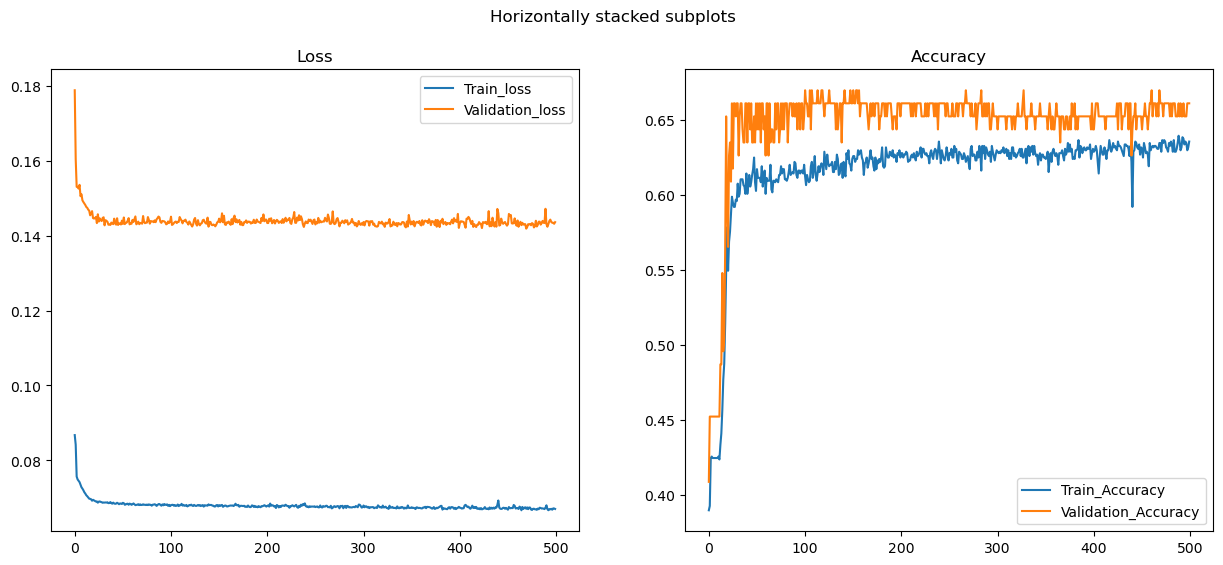

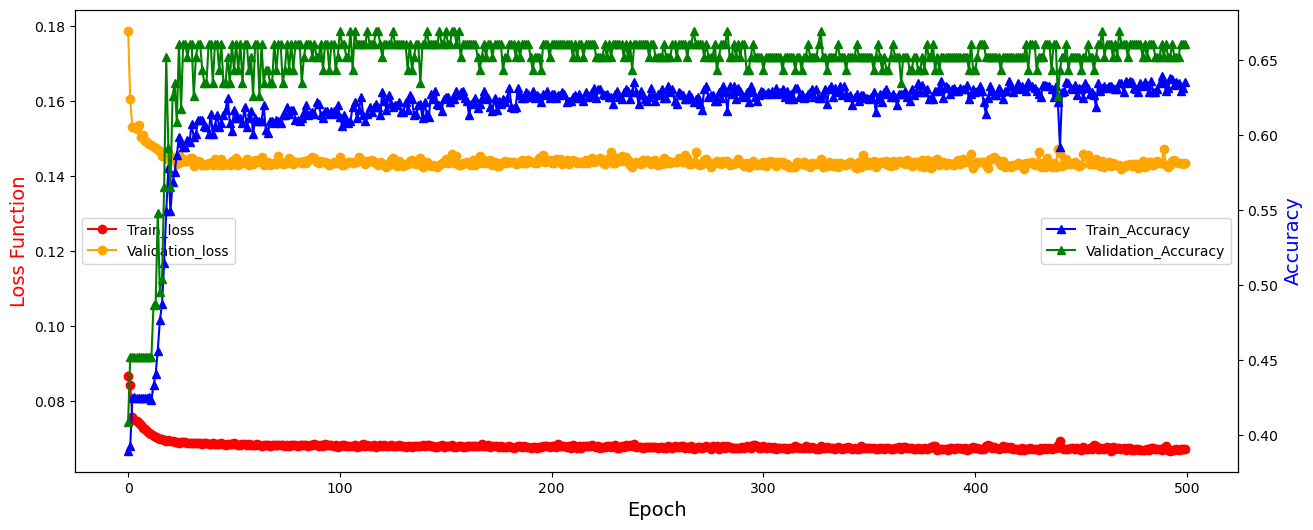

Current time: 92.008 minutes. Time expected till completion: 0.000 minutes
Finished training in: 92.009 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

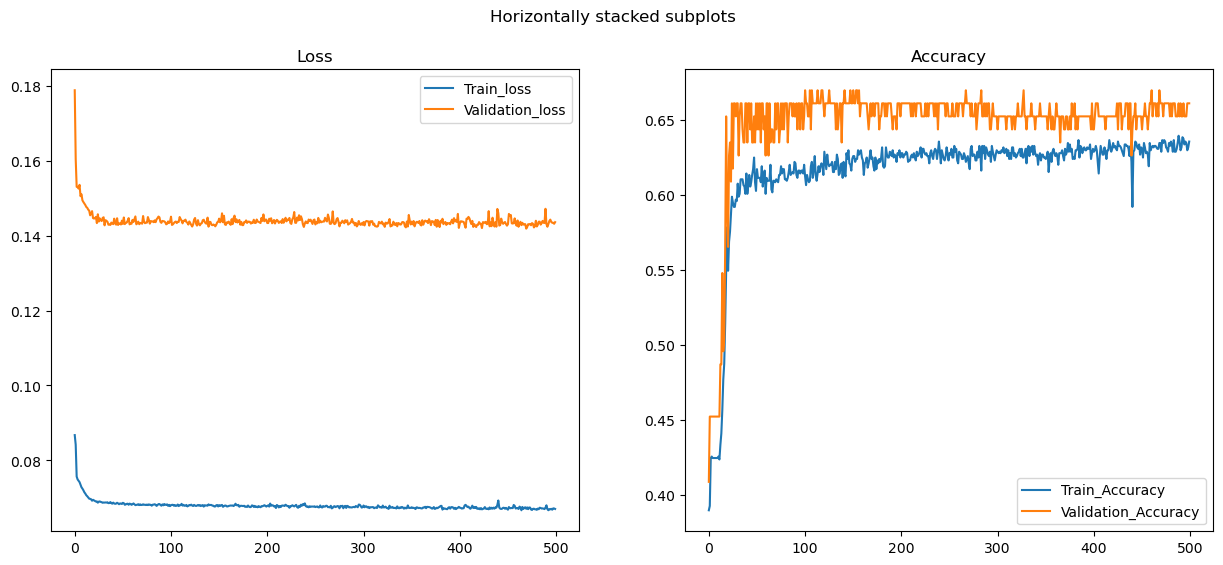

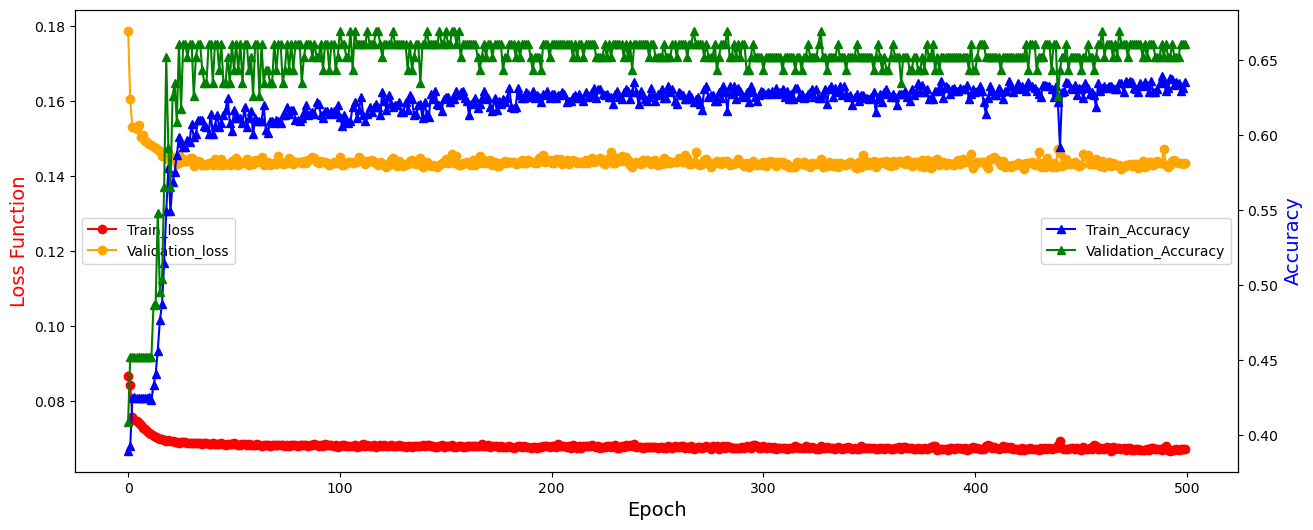

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 62.95938104448743%
Accuracy of the network on the 115 Validation instances: 66.08695652173913%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="01_5Conv_1Res_15FChannels.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points